In [1]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import calendar

from scipy.stats import linregress
from statsmodels.tsa.seasonal import seasonal_decompose


# EDA

## About Data


This dataset provides information on motor vehicle operators (drivers) involved in traffic collisions occurring on county and local roadways. The dataset reports details of all traffic collisions occurring on county and local roadways within Montgomery County, as collected via the Automated Crash Reporting System (ACRS) of the Maryland State Police, and reported by the Montgomery County Police, Gaithersburg Police, Rockville Police, or the Maryland-National Capital Park Police. This dataset shows each collision data recorded and the drivers involved.



## Data Overview

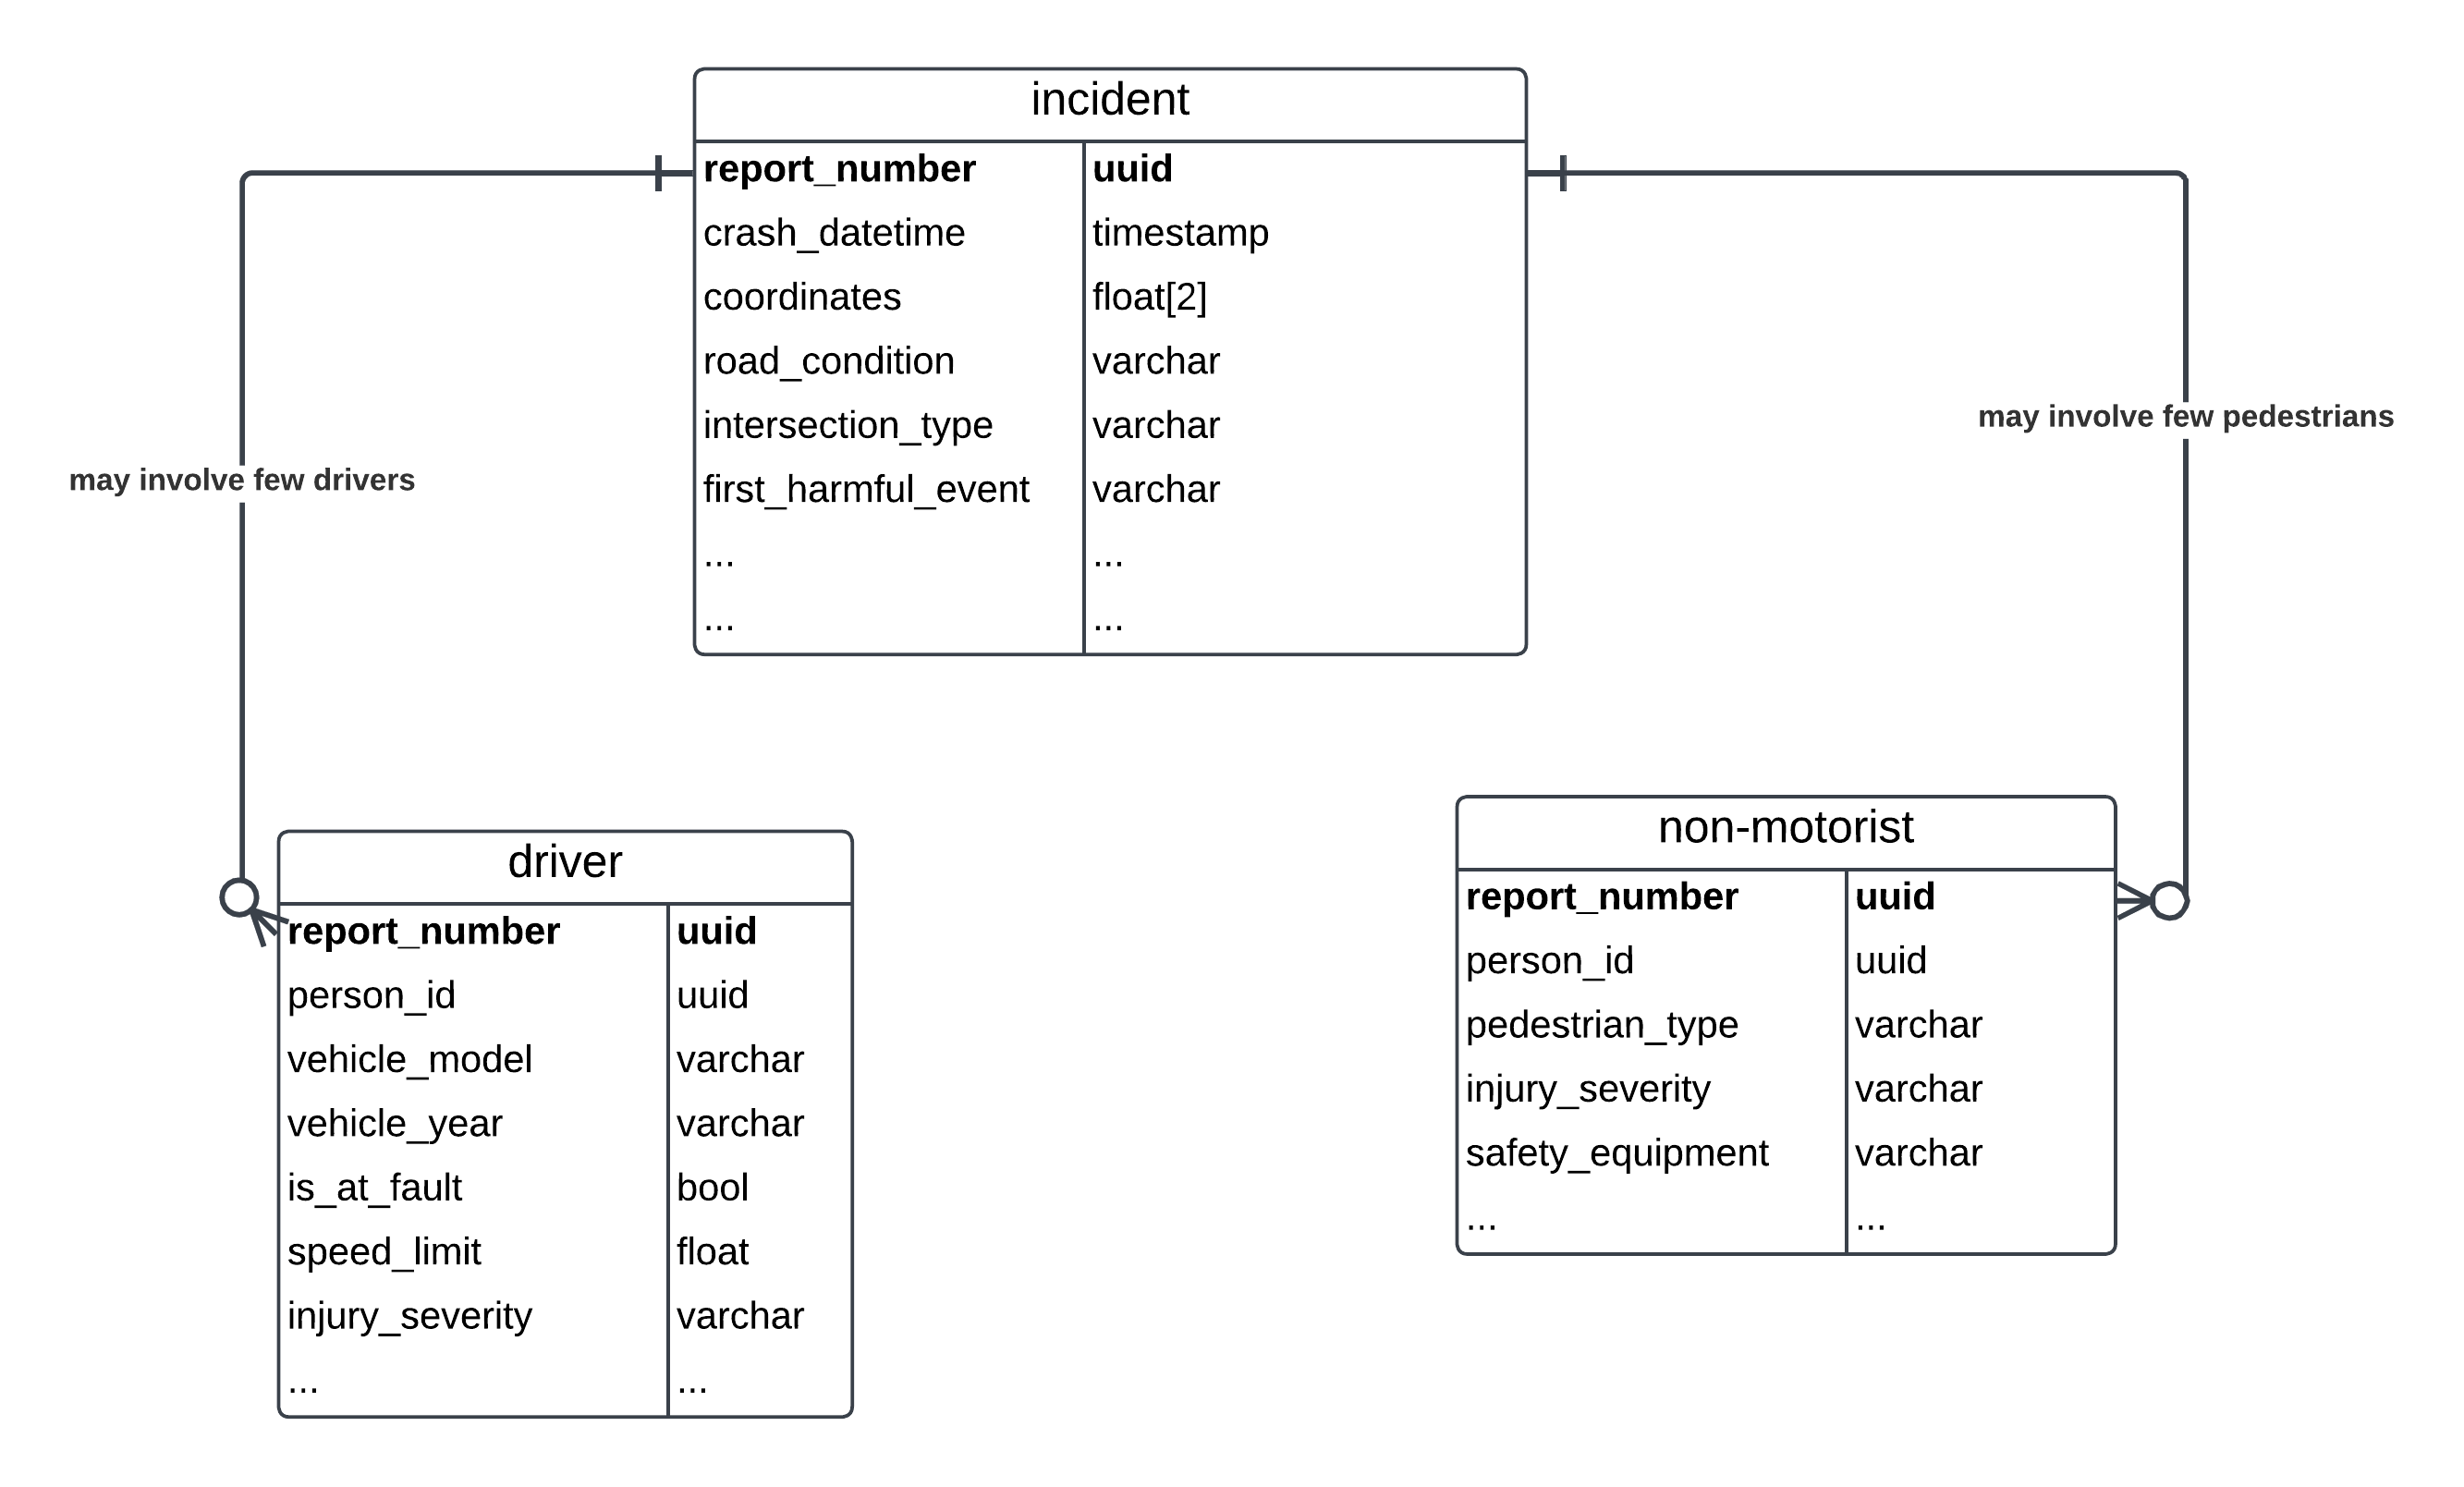

In [2]:
DB_PATH = "data/data.duckdb"

conn = duckdb.connect(database=DB_PATH, read_only=False)

In [3]:
conn.sql("SHOW TABLES;")

┌──────────────┐
│     name     │
│   varchar    │
├──────────────┤
│ drivers      │
│ incidents    │
│ non_motorist │
└──────────────┘

In [4]:
incidents_df = conn.sql("SELECT * FROM incidents;").fetchdf()
drivers_df = conn.sql("SELECT * FROM drivers").fetchdf()
nonmotorist_df = conn.sql("SELECT * FROM non_motorist").fetchdf()

#### Drivers table

In [5]:
conn.sql("SELECT * FROM drivers LIMIT 3;").fetchdf()

,report_number,local_case_number,agency_name,acrs_report_type,crash_datetime,route_type,road_name,cross-street_name,off-road_description,municipality,...,speed_limit,driverless_vehicle,parked_vehicle,vehicle_year,vehicle_make,vehicle_model,latitude,longitude,location,vehicle_type_group
0,DM8479000T,210020119.0,Takoma Park Police Depart,Property Damage Crash,2021-05-27 19:40:00,None,None,None,IN PARKING LOT,None,...,0,No,True,2017,HINO,TWK,38.987657,-76.987545,"(38.98765667, -76.987545)",None
1,MCP2970000R,15045937.0,MONTGOMERY,Property Damage Crash,2015-09-11 13:29:00,None,None,None,Parking Lot: \n2525 Ennalls Ave,None,...,5,No,False,2012,TOYOTA,SU,39.039917,-77.053649,"(39.03991652, -77.05364898)",Passenger Vehicles
2,MCP20160036,180040948.0,Montgomery County Police,Property Damage Crash,2018-08-17 14:25:00,None,None,None,PARKING LOT OF 16246 FREDERICK RD,None,...,15,No,False,2015,MAZD,TK,38.743373,-77.546997,"(38.743373, -77.54699707)",Passenger Vehicles


In [6]:
drivers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188090 entries, 0 to 188089
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   report_number                  188090 non-null  object        
 1   local_case_number              188070 non-null  float64       
 2   agency_name                    188090 non-null  object        
 3   acrs_report_type               188090 non-null  object        
 4   crash_datetime                 188090 non-null  datetime64[ns]
 5   route_type                     169696 non-null  object        
 6   road_name                      168741 non-null  object        
 7   cross-street_name              162133 non-null  object        
 8   off-road_description           17356 non-null   object        
 9   municipality                   19126 non-null   object        
 10  related_non-motorist           6040 non-null    object        
 11  

#### Incidents table

In [7]:
conn.sql("SELECT * FROM incidents LIMIT 3;").fetchdf()

,report_number,crash_datetime,hit,lane_direction,lane_type,number_of_lanes,direction,distance,road_grade,at_fault,first_harmful_event,second_harmful_event,junction,intersection_type,road_alignment,road_condition,road_division,distance_meters
0,MCP1123002M,2019-03-04 08:41:00,No,[West],None,2,EAST,200.0,GRADE DOWNHILL,DRIVER,OTHER VEHICLE,None,NON INTERSECTION,None,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",60.960
1,MCP21610009,2016-06-04 19:14:00,Yes,[East],None,1,EAST,500.0,LEVEL,DRIVER,PARKED VEHICLE,OTHER VEHICLE,NON INTERSECTION,None,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",152.400
2,MCP2790000P,2015-08-18 23:00:00,No,[South],None,2,SOUTH,30.0,LEVEL,UNKNOWN,PARKED VEHICLE,None,NON INTERSECTION,None,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",9.144


In [8]:
incidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106601 entries, 0 to 106600
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   report_number         106601 non-null  object 
 1   crash_datetime        106601 non-null  object 
 2   hit                   104906 non-null  object 
 3   lane_direction        93146 non-null   object 
 4   lane_type             17547 non-null   object 
 5   number_of_lanes       94261 non-null   object 
 6   direction             93158 non-null   object 
 7   distance              95021 non-null   float64
 8   road_grade            92530 non-null   object 
 9   at_fault              106601 non-null  object 
 10  first_harmful_event   105951 non-null  object 
 11  second_harmful_event  27871 non-null   object 
 12  junction              79122 non-null   object 
 13  intersection_type     50974 non-null   object 
 14  road_alignment        92748 non-null   object 
 15  

#### Non-motorist table

In [9]:
conn.sql("SELECT * FROM non_motorist LIMIT 3;").fetchdf()

,report_number,crash_date/time,person_id,pedestrian_type,pedestrian_movement,pedestrian_actions,pedestrian_location,at_fault,injury_severity,safety_equipment,pedestrian_category,is_helmet_present,is_lighting_present,is_reflective_wear
0,MCP9419004R,08/29/2023 02:00:00 PM,EEB1D2F0-0139-453B-8321-D30FC01D3FB7,OTHER,Other,OTHER,INSIDE BUILDING,No,POSSIBLE INJURY,NONE,OTHER,0.0,0.0,0.0
1,MCP3353001Z,11/30/2023 04:19:00 PM,2259BC33-1276-46BF-A263-15A1B7E079E5,PEDESTRIAN,Standing,NO IMPROPER ACTIONS,OTHER,No,POSSIBLE INJURY,None,PEDESTRIAN,NaN,NaN,NaN
2,MCP30750041,10/21/2023 10:34:00 PM,741BDE7D-D991-4C8D-9909-A400AD8C6B8C,OTHER,Other,OTHER,OTHER,Yes,SUSPECTED MINOR INJURY,None,OTHER,NaN,NaN,NaN


In [10]:
nonmotorist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6250 entries, 0 to 6249
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   report_number        6250 non-null   object 
 1   crash_date/time      6250 non-null   object 
 2   person_id            6250 non-null   object 
 3   pedestrian_type      6250 non-null   object 
 4   pedestrian_movement  6080 non-null   object 
 5   pedestrian_actions   5956 non-null   object 
 6   pedestrian_location  6097 non-null   object 
 7   at_fault             5963 non-null   object 
 8   injury_severity      6250 non-null   object 
 9   safety_equipment     3839 non-null   object 
 10  pedestrian_category  6250 non-null   object 
 11  is_helmet_present    3839 non-null   float64
 12  is_lighting_present  3839 non-null   float64
 13  is_reflective_wear   3839 non-null   float64
dtypes: float64(3), object(11)
memory usage: 683.7+ KB


### Missing Values

In [11]:
def plot_non_null_percentage(non_null_counts, total_rows, color='blue', title="Non null percentage"):
  
    # Calculate percentage of non-null values
    non_null_percentage = (non_null_counts / total_rows) * 100

    # Prepare data for plotting
    data = non_null_percentage.reset_index()
    data.columns = ['Column', 'Non-Null Percentage']

    # Plot
    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(data=data, x='Column', y='Non-Null Percentage', color=color, alpha=0.6)

    # Annotate bars with percentages
    for bar, percentage in zip(barplot.patches, non_null_percentage):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X-coordinate of the bar's center
            bar.get_height(),                 # Y-coordinate at the top of the bar
            f'{percentage:.1f}%',             # Text to display (formatted percentage)
            ha='center',                      # Horizontal alignment
            va='bottom',                      # Vertical alignment
            fontsize=10,                      # Font size
            color='black'                     # Font color
        )

    # Add labels and title
    plt.title(title, fontsize=16)
    plt.xlabel('Columns', fontsize=14)
    plt.ylabel('Non-Null Percentage (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.ylim(0, 105)  # Set a slightly higher Y-axis limit for better visibility of annotations
    plt.tight_layout()
    plt.show()


In [12]:
incidents_nonnull_counts = incidents_df.count()
drivers_nonnull_counts = drivers_df.count()
nonmotorist_nonnull_counts = nonmotorist_df.count()


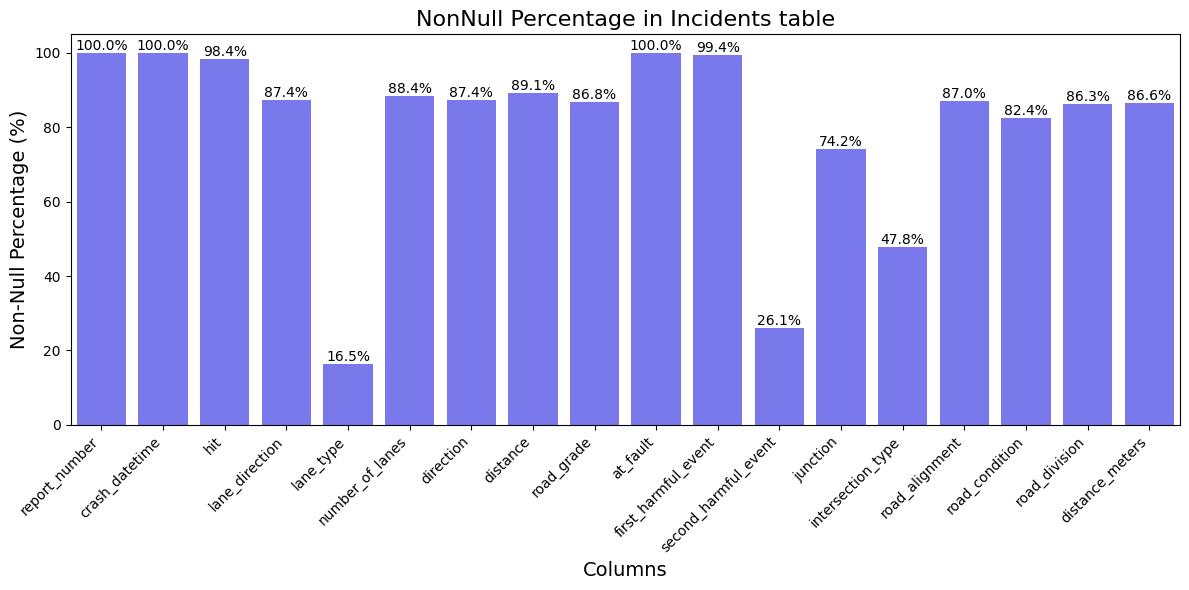

In [13]:
plot_non_null_percentage(incidents_nonnull_counts, len(incidents_df), title="NonNull Percentage in Incidents table")

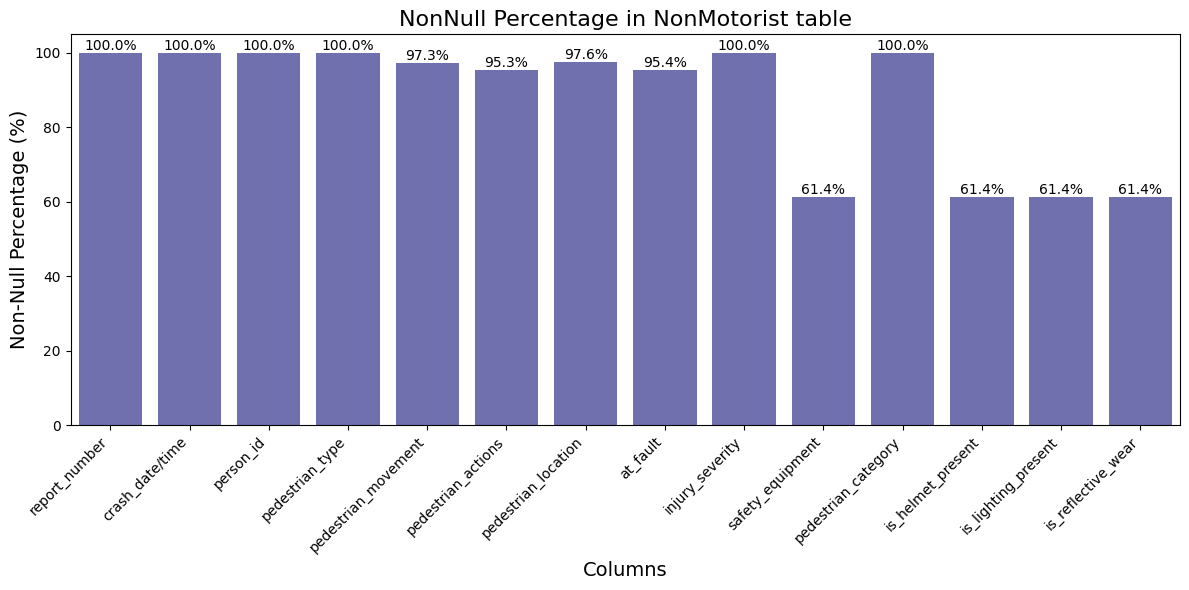

In [14]:
plot_non_null_percentage(nonmotorist_nonnull_counts, len(nonmotorist_df),
                         color="darkblue", title="NonNull Percentage in NonMotorist table")

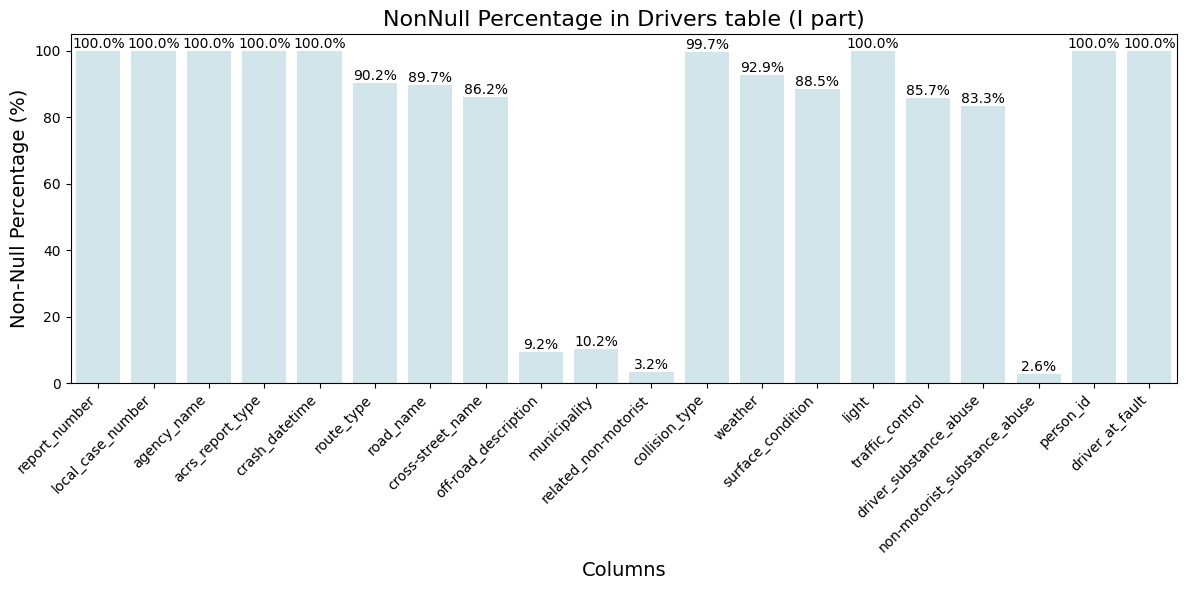

In [15]:
drivers_nonnull_counts_1st = drivers_nonnull_counts[:20]
drivers_nonnull_counts_2nd = drivers_nonnull_counts[20:]


plot_non_null_percentage(drivers_nonnull_counts_1st, len(drivers_df), color="lightblue", title="NonNull Percentage in Drivers table (I part)")

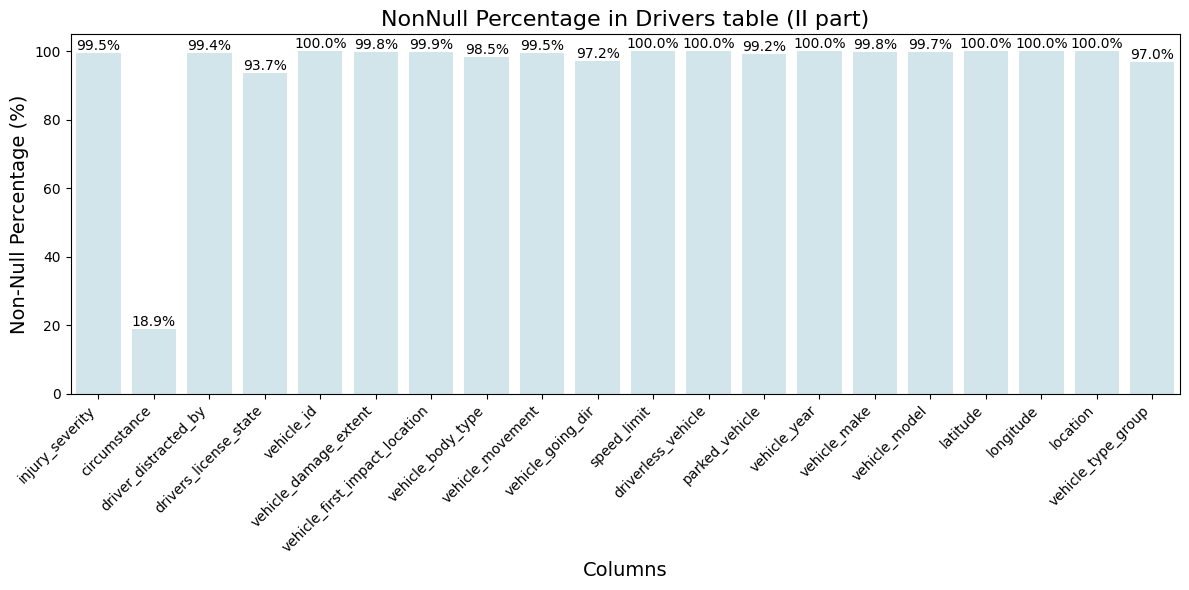

In [16]:
plot_non_null_percentage(drivers_nonnull_counts_2nd, len(drivers_df), color="lightblue", title="NonNull Percentage in Drivers table (II part)")

### Time-Series Analysis: Number of Collisions by Month

#### Definition of Severe/Serious-Injury Collision

A **serious collision** or **severe** is defined as an incident where either a driver or a non-motorist (e.g., pedestrian, cyclist) sustains a **fatal injury** or a **suspected serious injury** requiring hospitalization. Data is derived from collision reports in the `incidents`, `drivers`, and `non_motorist` tables, focusing on injury severities classified as `'FATAL INJURY'` or `'SUSPECTED SERIOUS INJURY'`. Identifying serious collisions is crucial for traffic safety analysis, policy development, and effective resource allocation to reduce severe road incidents and improve emergency responses.

#### Group number of collisions by month

In [17]:
collision_grouped_by_month = conn.sql("""
    SELECT 
        strftime(CAST(crash_datetime AS TIMESTAMP), '%Y') AS year,
        strftime(CAST(crash_datetime AS TIMESTAMP), '%m') AS month,
        COUNT(*) AS number_of_collisions
    FROM incidents
    WHERE CAST(crash_datetime AS TIMESTAMP) <= TIMESTAMP '2024-10-01'
    GROUP BY year, month
    ORDER BY year, month;
""").fetchdf()


collision_grouped_by_month["date"] = pd.to_datetime(collision_grouped_by_month['year'].astype(str) + '-' + collision_grouped_by_month['month'])
collision_grouped_by_month['quarter'] = collision_grouped_by_month['date'].dt.to_period('Q').astype(str)
collision_grouped_by_quarter = collision_grouped_by_month.groupby('quarter', as_index=False)['number_of_collisions'].sum()
collision_grouped_by_year = collision_grouped_by_month.groupby('year', as_index=False)['number_of_collisions'].sum()

In [18]:
serious_collision_grouped_by_month = conn.sql("""
    SELECT 
        strftime(CAST(I.crash_datetime AS TIMESTAMP), '%Y') AS year,
        strftime(CAST(I.crash_datetime AS TIMESTAMP), '%m') AS month,
        COUNT(*) AS number_of_collisions
    FROM incidents I 
    LEFT JOIN drivers D ON I.report_number = D.report_number 
    LEFT JOIN non_motorist NM ON I.report_number = NM.report_number
    WHERE CAST(I.crash_datetime AS TIMESTAMP) <= TIMESTAMP '2024-10-01' 
    AND (
        D.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY') 
        OR NM.injury_severity IN ('FATAL INJURY', 'SUSPECTED SERIOUS INJURY')
    )
    GROUP BY year, month
    ORDER BY year, month;
""").fetchdf()

serious_collision_grouped_by_month["date"] = pd.to_datetime(serious_collision_grouped_by_month['year'].astype(str) + '-' + serious_collision_grouped_by_month['month'])
serious_collision_grouped_by_month['quarter'] = serious_collision_grouped_by_month['date'].dt.to_period('Q').astype(str)
serious_collision_grouped_by_quarter = serious_collision_grouped_by_month.groupby('quarter', as_index=False)['number_of_collisions'].sum()
serious_collision_grouped_by_year = serious_collision_grouped_by_month.groupby('year', as_index=False)['number_of_collisions'].sum()



#### Plot collisions by month and by year

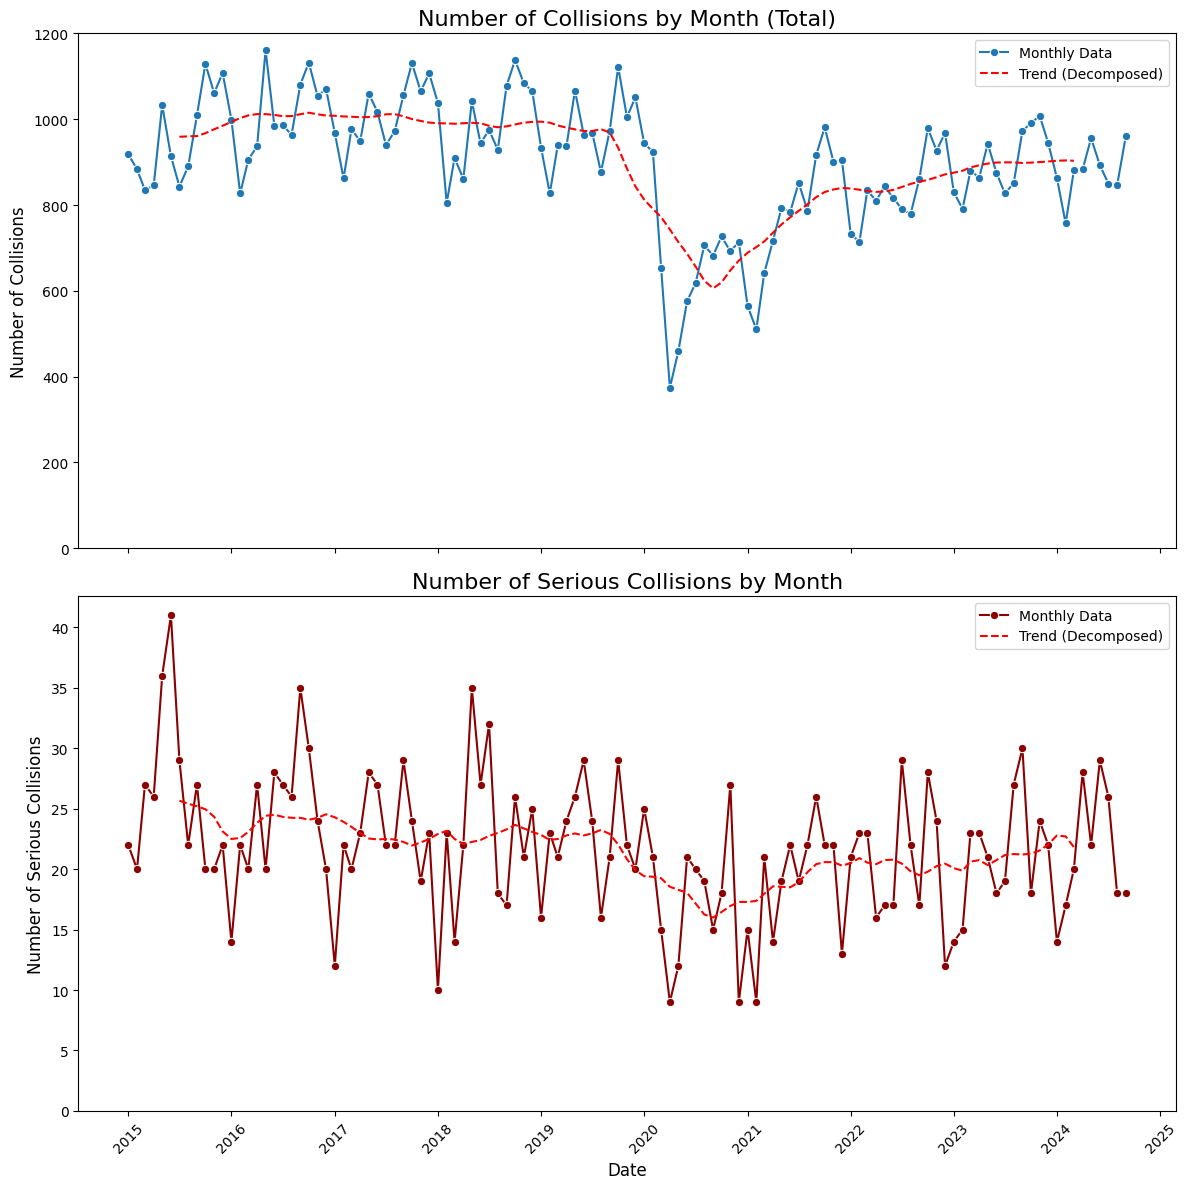

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set index for decomposition for total collisions
collision_grouped_by_month.set_index('date', inplace=True)
decomposition_total = seasonal_decompose(collision_grouped_by_month['number_of_collisions'], model='additive', period=12)
trend_total = decomposition_total.trend
collision_grouped_by_month.reset_index(inplace=True)

# Set index for decomposition for serious collisions
serious_collision_grouped_by_month.set_index('date', inplace=True)
decomposition_serious = seasonal_decompose(serious_collision_grouped_by_month['number_of_collisions'], model='additive', period=12)
trend_serious = decomposition_serious.trend
serious_collision_grouped_by_month.reset_index(inplace=True)

# Create the figure and axes
fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Plot for total collisions
sns.lineplot(data=collision_grouped_by_month, x='date', y='number_of_collisions', marker='o', label='Monthly Data', ax=ax[0])
ax[0].plot(collision_grouped_by_month['date'], trend_total, color='red', label='Trend (Decomposed)', linestyle='--')
ax[0].set_title('Number of Collisions by Month (Total)', fontsize=16)
ax[0].set_ylabel('Number of Collisions', fontsize=12)
ax[0].legend()
ax[0].set_ylim(0)  # Y-axis starts at 0
ax[0].tick_params(axis='x', rotation=45)

# Plot for serious collisions
sns.lineplot(data=serious_collision_grouped_by_month, x='date', y='number_of_collisions', marker='o', label='Monthly Data', color="darkred", ax=ax[1])
ax[1].plot(serious_collision_grouped_by_month['date'], trend_serious, color='red', label='Trend (Decomposed)', linestyle='--')
ax[1].set_title('Number of Serious Collisions by Month', fontsize=16)
ax[1].set_xlabel('Date', fontsize=12)
ax[1].set_ylabel('Number of Serious Collisions', fontsize=12)
ax[1].legend()
ax[1].set_ylim(0)  # Y-axis starts at 0
ax[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


#### Montly seasonality: Total Collisions

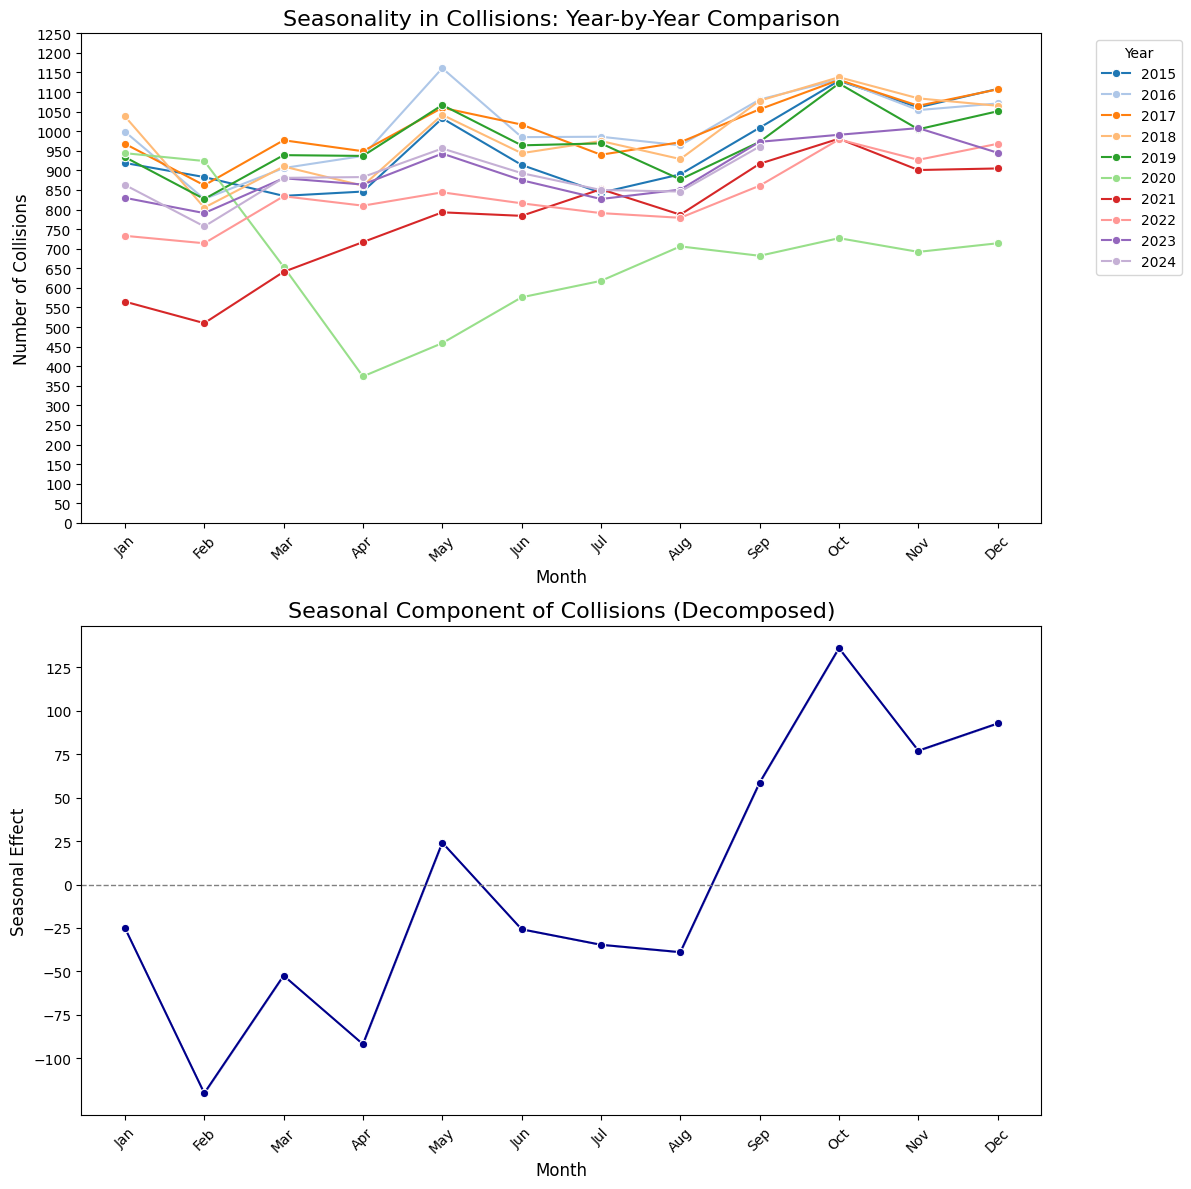

In [20]:
# Ensure the data is time-indexed for decomposition
collision_grouped_by_month.set_index('date', inplace=True)
decomposition = seasonal_decompose(collision_grouped_by_month['number_of_collisions'], model='additive', period=12)
seasonality = decomposition.seasonal
collision_grouped_by_month.reset_index(inplace=True)
collision_grouped_by_month['month_name'] = collision_grouped_by_month['date'].dt.strftime('%b')

seasonal_df = seasonality.reset_index()
seasonal_df['month_name'] = seasonal_df['date'].dt.strftime('%b')
seasonal_df['month_order'] = seasonal_df['month_name'].map(lambda x: list(calendar.month_abbr).index(x))
seasonal_df = seasonal_df.sort_values('month_order')

# Create the figure and axes for two stacked plots
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

y_ticks = np.arange(0, 1300, 50)

# Top plot: Year-by-year trends
sns.lineplot(
    data=collision_grouped_by_month, 
    x='month_name', 
    y='number_of_collisions', 
    hue='year', 
    marker='o', 
    palette='tab20', 
    ax=axes[0]
)
axes[0].set_title('Seasonality in Collisions: Year-by-Year Comparison', fontsize=16)
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Number of Collisions', fontsize=12)
axes[0].legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, 1200)
axes[0].set_yticks(y_ticks)

# Bottom plot: Seasonal component from decomposition
sns.lineplot(
    data=seasonal_df, 
    x='month_name', 
    y='seasonal', 
    marker='o', 
    color='darkblue', 
    ax=axes[1]
)
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)  # Add horizontal dashed line at zero
axes[1].set_title('Seasonal Component of Collisions (Decomposed)', fontsize=16)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Seasonal Effect', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_yticks(np.arange(-100, 126, 25))

# Adjust layout
plt.tight_layout()
plt.show()


**Observations and Comments**

By overlaying collisions for each year, we see a clear and noticeable seasonality in number of collisions. Seasonal effect is highest at October whereas January, February, March and April tend to have small (negative seasonal effect). 

Another observation is Spring of 2020 which is anomaly among all years very likely due to COVID19 pandemy and lockdown. The number of collisions fell down noticably. 
There is an official document from the Governor of State Maryland that require all person to stay at home as much as possible.
[Governor of Maryalnd Order 2020, 30 March](https://health.maryland.gov/massage/Documents/exeorder58.pdf)



#### Montly Seasonality: Severe (Serious-injury) Collisions

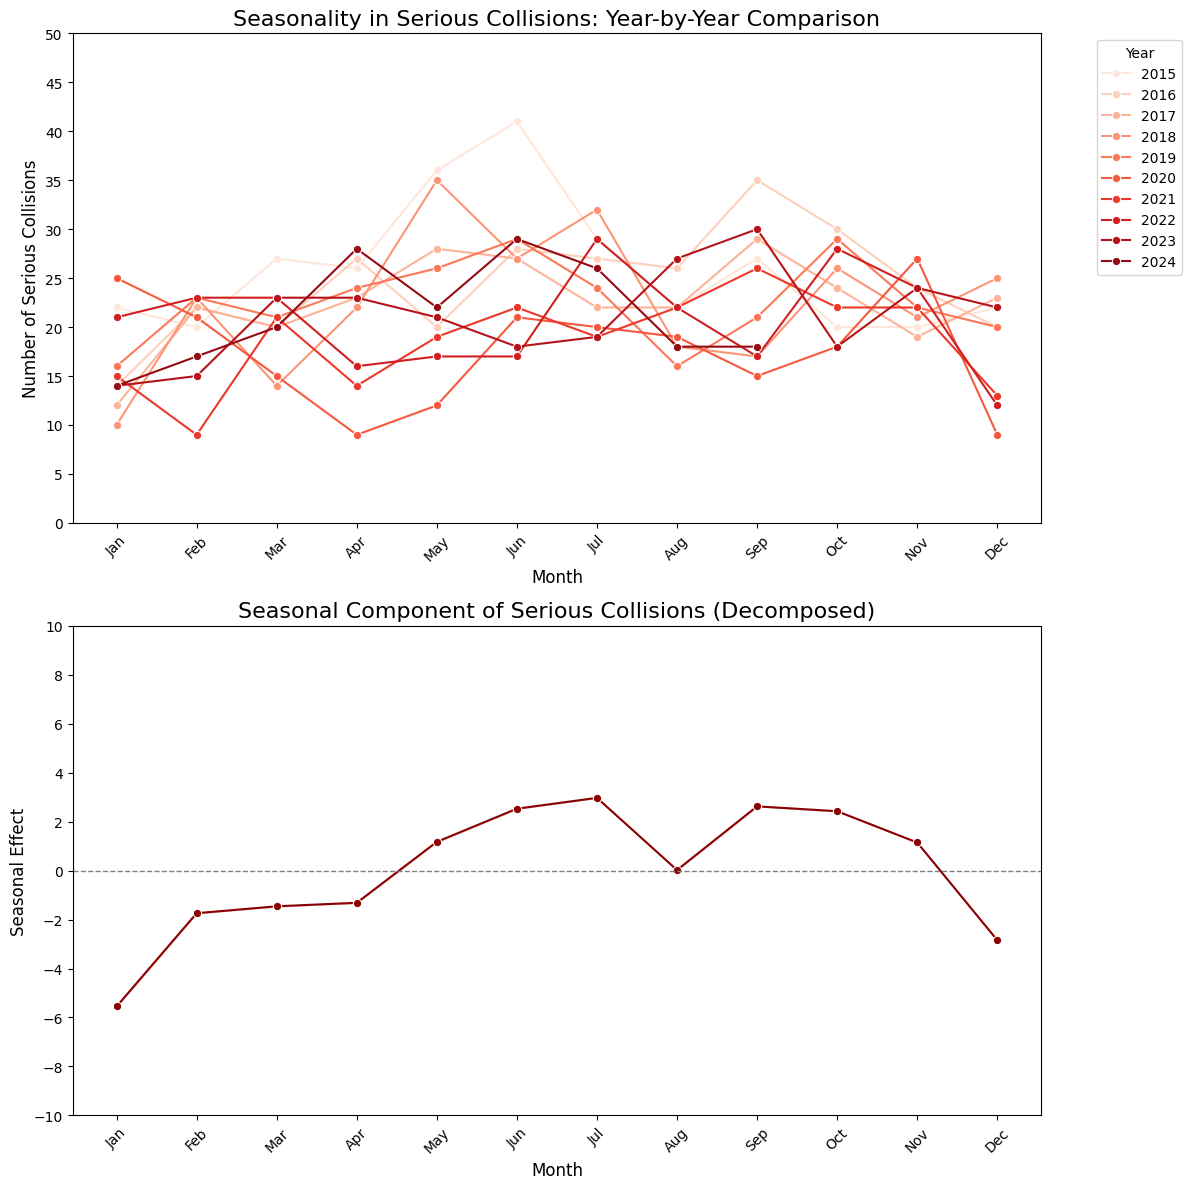

In [21]:
# Ensure the data is time-indexed for decomposition
serious_collision_grouped_by_month.set_index('date', inplace=True)
decomposition = seasonal_decompose(serious_collision_grouped_by_month['number_of_collisions'], model='additive', period=12)
seasonality = decomposition.seasonal
serious_collision_grouped_by_month.reset_index(inplace=True)
serious_collision_grouped_by_month['month_name'] = serious_collision_grouped_by_month['date'].dt.strftime('%b')

# Prepare seasonal data for plotting
seasonal_df = seasonality.reset_index()
seasonal_df['month_name'] = seasonal_df['date'].dt.strftime('%b')
seasonal_df['month_order'] = seasonal_df['month_name'].map(lambda x: list(calendar.month_abbr).index(x))
seasonal_df = seasonal_df.sort_values('month_order')

# Create the figure and axes for two stacked plots
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

y_ticks = np.arange(0, 51, 5)  # Adjusted for serious collisions

# Top plot: Year-by-year trends (shades of red)
sns.lineplot(
    data=serious_collision_grouped_by_month, 
    x='month_name', 
    y='number_of_collisions', 
    hue='year', 
    marker='o', 
    palette='Reds',  # Use shades of red
    ax=axes[0]
)
axes[0].set_title('Seasonality in Serious Collisions: Year-by-Year Comparison', fontsize=16)
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Number of Serious Collisions', fontsize=12)
axes[0].legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, 50)  # Adjusted for serious collisions
axes[0].set_yticks(y_ticks)

# Bottom plot: Seasonal component from decomposition
sns.lineplot(
    data=seasonal_df, 
    x='month_name', 
    y='seasonal', 
    marker='o', 
    color='darkred',  # Use dark red for serious collisions
    ax=axes[1]
)
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)  # Add horizontal dashed line at zero
axes[1].set_title('Seasonal Component of Serious Collisions (Decomposed)', fontsize=16)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Seasonal Effect', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_yticks(np.arange(-10, 11, 2))  # Adjusted for serious collisions

# Adjust layout
plt.tight_layout()
plt.show()


**Observations and Comments**

Severe collisions tend to have less expressed seasonality and larger variance in some seasons. Looking at seasonal effect, we see that Winter months have noticably fewer severe road incidents in comparison with Summer and Autumn. I also have to notice, though it looks like a significant differnce, this seasonality in severe collisions might be affected by the fact that winter has fewer total collisions on average.


#### Heatmap: yearly collisions by month

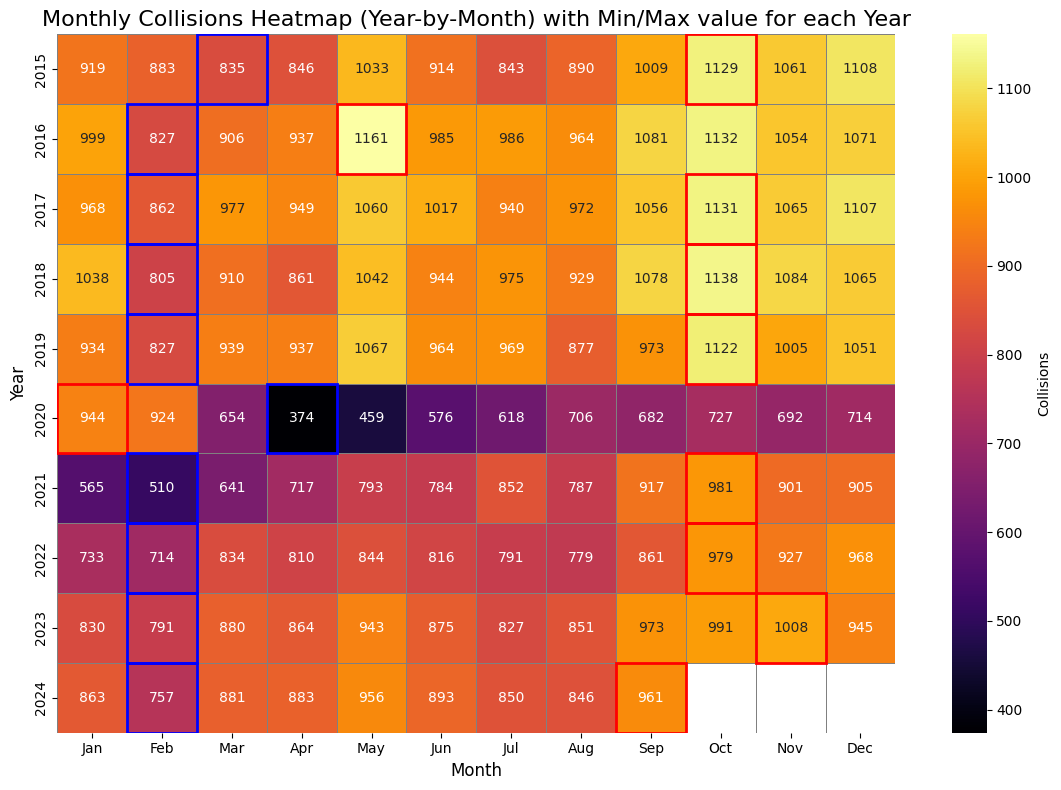

In [22]:
collision_grouped_by_month['month_name'] = collision_grouped_by_month['month'].astype(int).map(lambda x: calendar.month_abbr[x])

# Create a pivot table for heatmap visualization with month names
heatmap_data = collision_grouped_by_month.pivot(index='year', columns='month_name', values='number_of_collisions')

# Ensure columns are sorted by correct month order
month_order = list(calendar.month_abbr)[1:]  # ['Jan', 'Feb', ..., 'Dec']
heatmap_data = heatmap_data[month_order]  # Reorder columns based on month order

# Create masks for min and max values
min_mask = heatmap_data.eq(heatmap_data.min(axis=1), axis=0)
max_mask = heatmap_data.eq(heatmap_data.max(axis=1), axis=0)

# Plot the base heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data, 
    cmap='inferno', 
    annot=True, 
    fmt='.0f', 
    cbar_kws={'label': 'Collisions'}, 
    linewidths=0.5,
    linecolor='gray',
    square=True
)

# Add borders for min and max values
for i in range(heatmap_data.shape[0]):  # Iterate over rows (years)
    for j in range(heatmap_data.shape[1]):  # Iterate over columns (months)
        if min_mask.iloc[i, j]:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='blue', lw=2))
        elif max_mask.iloc[i, j]:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=2))

# Add title and labels
plt.title('Monthly Collisions Heatmap (Year-by-Month) with Min/Max value for each Year', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.tight_layout()
plt.show()

#### Time-Series Diagnostics: Total Colisions

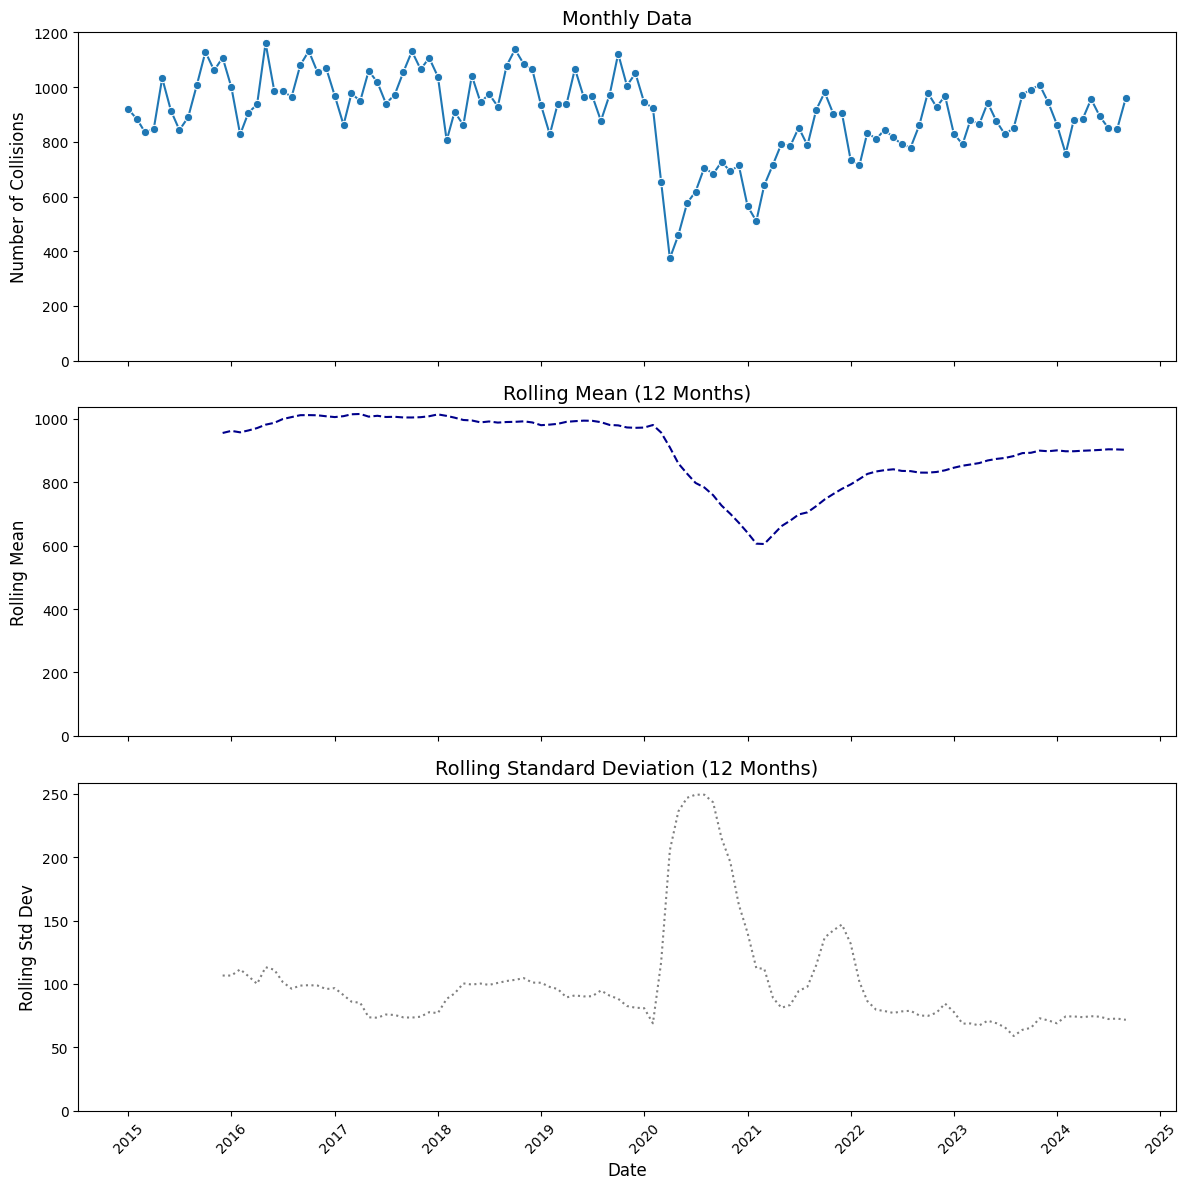

In [23]:
# Compute rolling statistics
rolling_mean = collision_grouped_by_month['number_of_collisions'].rolling(window=12).mean()
rolling_std = collision_grouped_by_month['number_of_collisions'].rolling(window=12).std()

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot the original time series
sns.lineplot(data=collision_grouped_by_month, x='date', y='number_of_collisions', marker='o', ax=axes[0])
axes[0].set_title('Monthly Data', fontsize=14)
axes[0].set_ylabel('Number of Collisions', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0)  # Ensure y-axis starts at 0

# Plot the rolling mean
axes[1].plot(collision_grouped_by_month['date'], rolling_mean, color="darkblue", linestyle='--')
axes[1].set_title('Rolling Mean (12 Months)', fontsize=14)
axes[1].set_ylabel('Rolling Mean', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(0)  # Ensure y-axis starts at 0

# Plot the rolling standard deviation
axes[2].plot(collision_grouped_by_month['date'], rolling_std, color='gray', linestyle=':')
axes[2].set_title('Rolling Standard Deviation (12 Months)', fontsize=14)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Rolling Std Dev', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_ylim(0)  # Ensure y-axis starts at 0

# Adjust layout
plt.tight_layout()
plt.show()


 **Observations and Comments**

As mentioned earlier, we have identified clear seasonality in the time series of collisions in Maryland State. These diagnostic plots can be interpreted as follows:

1. **2020 is an anomaly and a structural break in our time series.**
2. **The number of collisions as a time series is not stationary due to Spring 2020 and non-constant variance.**
3. **Modeling this series may be feasible if we preprocess and smooth the outlier in 2020.**  
   - This can be achieved through interpolation between 2020 and 2021 or by using another technique.


#### Time-Series Diagnostics: Severe Collisions

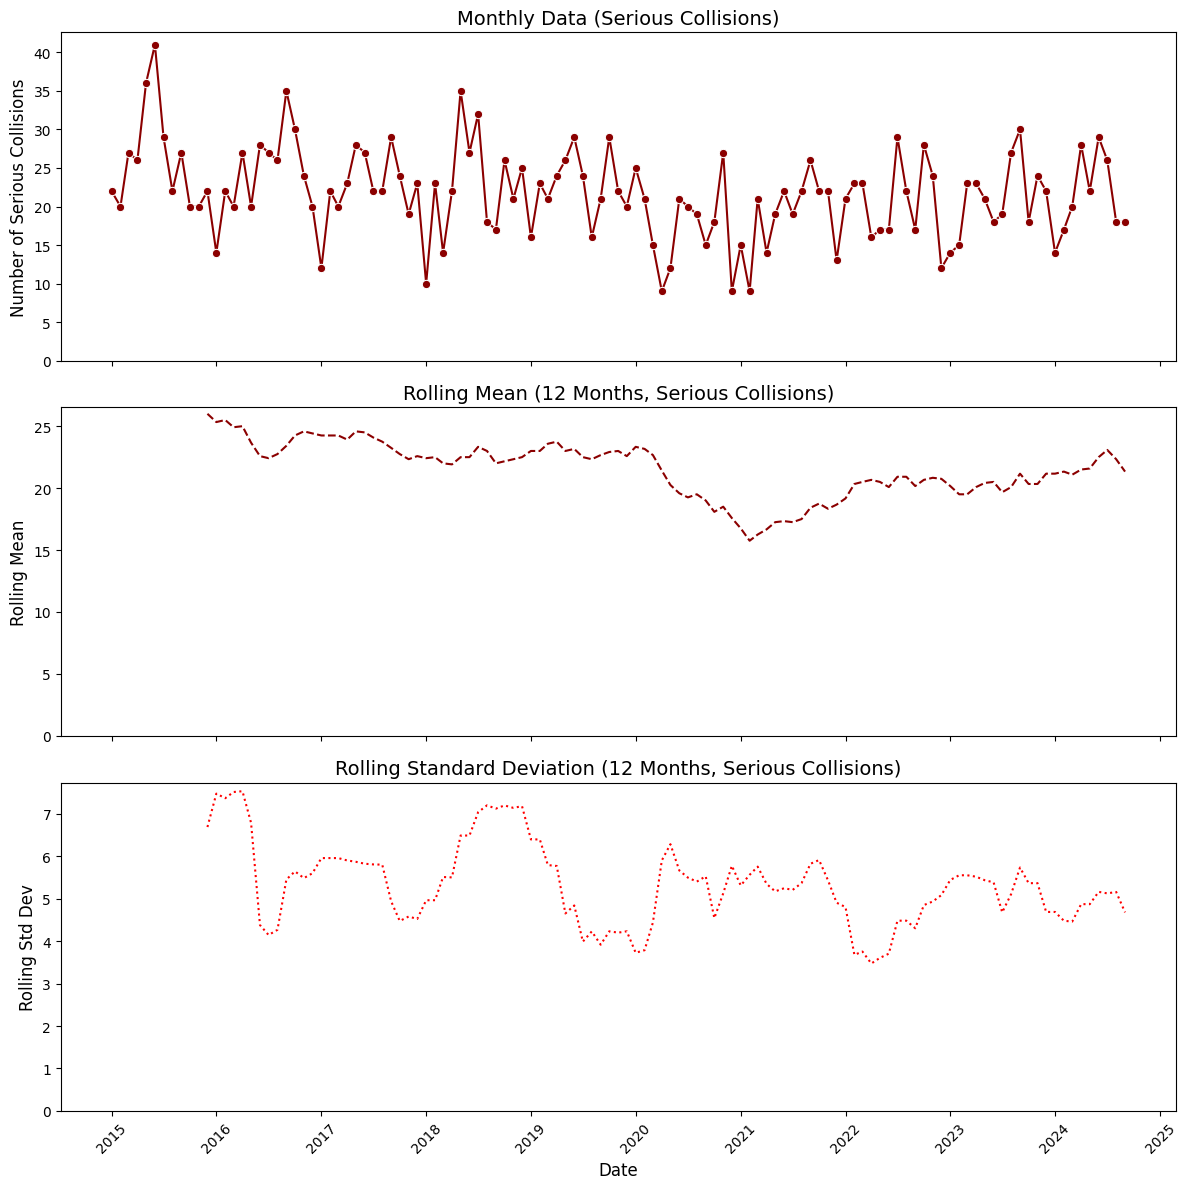

In [25]:
# Compute rolling statistics for serious collisions
rolling_mean_serious = serious_collision_grouped_by_month['number_of_collisions'].rolling(window=12).mean()
rolling_std_serious = serious_collision_grouped_by_month['number_of_collisions'].rolling(window=12).std()

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot the original time series for serious collisions
sns.lineplot(data=serious_collision_grouped_by_month, x='date', y='number_of_collisions', color="darkred", marker='o', ax=axes[0])
axes[0].set_title('Monthly Data (Serious Collisions)', fontsize=14)
axes[0].set_ylabel('Number of Serious Collisions', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0)  # Ensure y-axis starts at 0

# Plot the rolling mean for serious collisions
axes[1].plot(serious_collision_grouped_by_month['date'], rolling_mean_serious, color="darkred", linestyle='--')
axes[1].set_title('Rolling Mean (12 Months, Serious Collisions)', fontsize=14)
axes[1].set_ylabel('Rolling Mean', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(0)  # Ensure y-axis starts at 0

# Plot the rolling standard deviation for serious collisions
axes[2].plot(serious_collision_grouped_by_month['date'], rolling_std_serious, color='red', linestyle=':')
axes[2].set_title('Rolling Standard Deviation (12 Months, Serious Collisions)', fontsize=14)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Rolling Std Dev', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_ylim(0)  # Ensure y-axis starts at 0

# Adjust layout
plt.tight_layout()
plt.show()


 **Observations and Comments**

Surprisingly enough, COVID19 lockdown in **March of 2020 did not affect number of severe collisions as much as number of total collisions.**
The number of collisions reached its minimum on April 2020 in anyway, but the fall is not that big as in total collisions.

Another interesting observation is that **variance of severe collisions seems to have seasonality and far from being constant.**
